<a href="https://colab.research.google.com/github/ddfadela/personalized-healthcare-ai/blob/main/Canal_Ident_KAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykan

In [ ]:
from kan import KAN
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = pd.read_csv('/content/Canal_data.csv')
df.head()


,t,e1,e2,e3,y
0,0.13,0.003401,0.037378,0.0,-0.003133
1,0.26,-0.003133,0.003401,0.0,-0.016288
2,0.39,-0.016288,-0.003133,0.0,-0.018024
3,0.52,-0.018024,-0.016288,0.0,-0.019066
4,0.65,-0.019066,-0.018024,0.0,-0.033928


In [ ]:
target_column_name = "y"
time_ = df['t']
df = df.drop('t',axis=1)
X  = df.drop([target_column_name],axis=1)
y = df[target_column_name]

X = np.array(X)
y = np.array(y)
y = y.reshape(-1,1)
# print(X.shape, y.shape)

In [ ]:

# Split whole data to train and remainings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # Changed test_size to 0.2

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# Covert data to torch tensor
train_input = torch.tensor(X_train, dtype=torch.float32).to(device)
train_label = torch.tensor(y_train, dtype=torch.float32).to(device)
test_input = torch.tensor(X_test, dtype=torch.float32).to(device)
test_label = torch.tensor(y_test, dtype=torch.float32).to(device)

dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}


(921, 3) (231, 3) (921, 1) (231, 1)


In [ ]:
def train_mse():
    # Get predicted from the model
    y_pred = model(dataset['train_input'])
    # Detach y_pred from the computation graph and convert to NumPy array
    return torch.tensor(mean_squared_error(dataset['train_label'].cpu().detach().numpy(), y_pred.cpu().detach().numpy())).to(device) # Return a PyTorch scalar
def test_mse():
    # Get predicted from the model
    y_pred = model(dataset['test_input'])
    # Detach y_pred from the computation graph and convert to NumPy array
    return torch.tensor(mean_squared_error(dataset['test_label'].cpu().detach().numpy(), y_pred.cpu().detach().numpy())).to(device) # Return a PyTorch scalar
sauvegarde_test = []
sauvegarde_train = []
i = 1
for nb_layer in [40]:#, 20, 40]:
  for g in [5]:#, 10, 15, 20]:
    print(f"g = {g}, nb_layer = {nb_layer}")
    # Create KAN
    model = KAN(width=[X_train.shape[1], nb_layer,y_train.shape[1]], grid= g, k = 3, device=device)
    # results = model.fit(dataset, opt="LBFGS", steps=500, lamb_entropy=2, lamb_l1= 2, lr = 0.01, metrics=(train_mse, test_mse))
    results = model.fit(dataset, opt="Adam", steps=1000, lamb_entropy=2, lamb_l1= 2, lr=0.01, metrics=(train_mse, test_mse))

    results['train_mse'][-1], results['test_mse'][-1]
    sauvegarde_test.append(results['test_loss'])
    sauvegarde_train.append(results['train_loss'])
# print(sauvegarde_test)
# print(sauvegarde_train)

g = 5, nb_layer = 40
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-02 | test_loss: 1.87e-02 | reg: 3.52e+01 | : 100%|█| 1000/1000 [00:19<00:00, 50.


saving model version 0.1


In [ ]:
print(np.array(sauvegarde_train).shape)

(1, 1000)


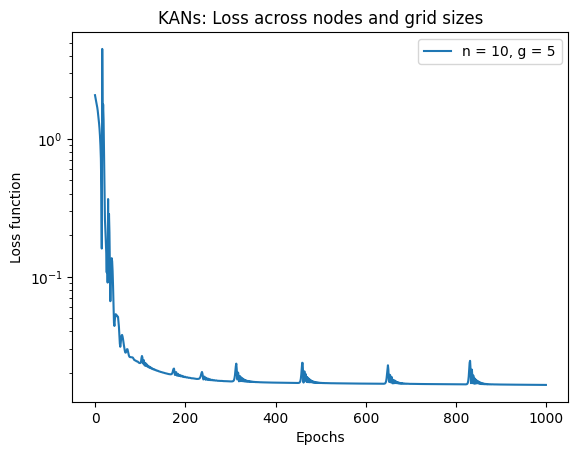

In [ ]:
i = 0
for nb_layer in [10]:#, 20, 40]:
  for g in [5]:#, 10, 15, 20]:
      plt.plot(np.array(sauvegarde_train[i][:]).transpose(), label = f'n = {nb_layer}, g = {g}' )
      i+=1

plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title('KANs: Loss across nodes and grid sizes')
plt.legend()
plt.yscale('log')
plt.show()

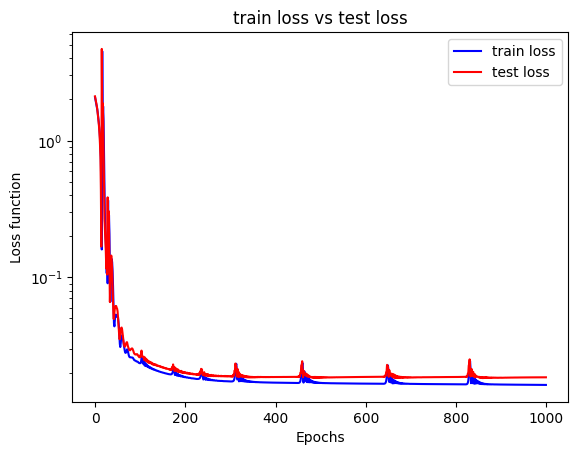

In [ ]:
plt.plot(results['train_loss'], label='train loss', color='blue')
plt.plot(results['test_loss'], label='test loss', color='red')
plt.yscale('log')

plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title('train loss vs test loss')
plt.legend()
plt.show()

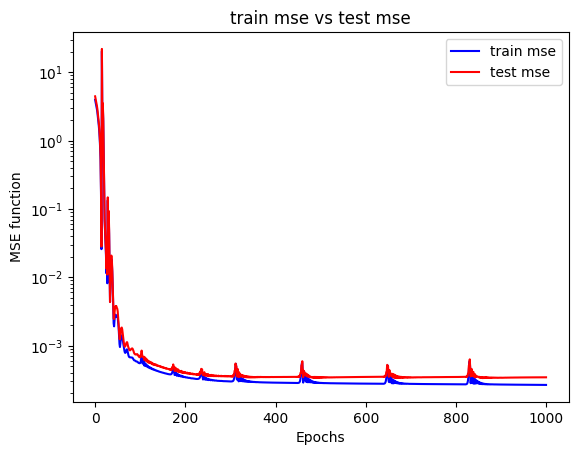

In [ ]:
plt.plot(results['train_mse'], label='train mse', color='blue')
plt.plot(results['test_mse'], label='test mse', color='red')
plt.xlabel('Epochs')
plt.ylabel('MSE function')
plt.title('train mse vs test mse')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
train_size = 0.8
X_train = X[:int(train_size*len(X))]
X_test = X[int(train_size*len(X)):]
y_train = y[:int(train_size*len(y))]
y_test = y[int(train_size*len(y)):]


# Move tensors to the correct device
train_input = torch.tensor(X_train, dtype=torch.float32).to(device) # Move to device
train_label = torch.tensor(y_train, dtype=torch.float32).to(device) # Move to device
test_input = torch.tensor(X_test, dtype=torch.float32).to(device) # Move to device
test_label = torch.tensor(y_test, dtype=torch.float32).to(device) # Move to device

y_pred_train = model.forward(train_input)
y_pred_train = y_pred_train.cpu().detach().numpy()

y_pred_test = model.forward(test_input)
y_pred_test = y_pred_test.cpu().detach().numpy()

train_data = {}
test_data = {}
train_data['train_label'] = train_label.cpu().detach().numpy()
train_data['predicted_train'] = y_pred_train

test_data['test_label'] = test_label.cpu().detach().numpy()
test_data['predicted_test']   = y_pred_test

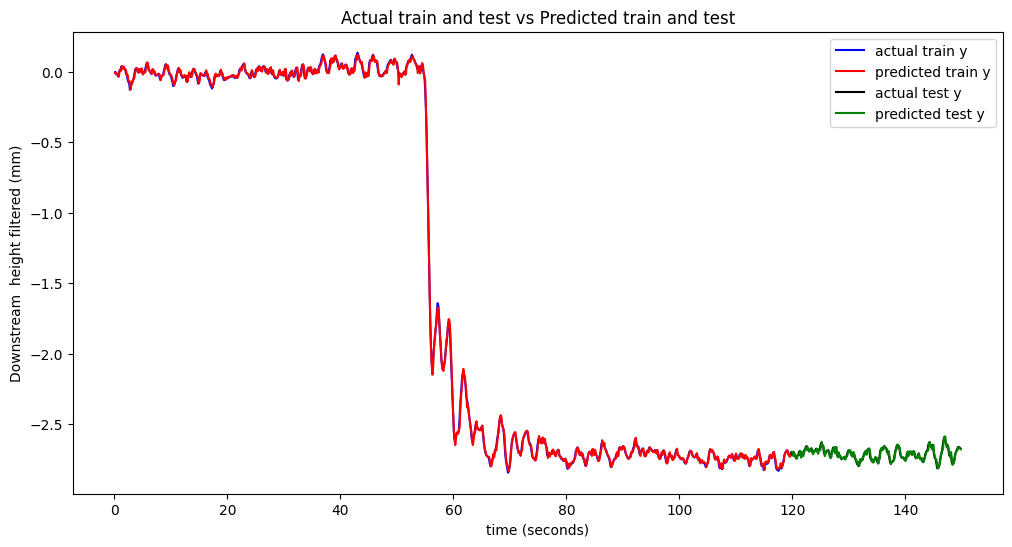

In [ ]:
plt.figure(figsize=(12, 6))
time_train = np.array(time_)
time_ = time_train.reshape(-1,1)
time_train = time_[:int(train_size*len(time_))]
time_test = time_[int(train_size*len(time_)):]

plt.plot(time_train, train_data['train_label'], label='actual train y', color='blue')
plt.plot(time_train, train_data['predicted_train'], label='predicted train y', color='red')
plt.plot(time_test, test_data['test_label'], label='actual test y', color='black')
plt.plot(time_test, test_data['predicted_test'], label='predicted test y', color='green')
plt.xlabel('time (seconds)')

plt.ylabel('Downstream  height filtered (mm)')
plt.title('Actual train and test vs Predicted train and test')
plt.legend()
plt.show()

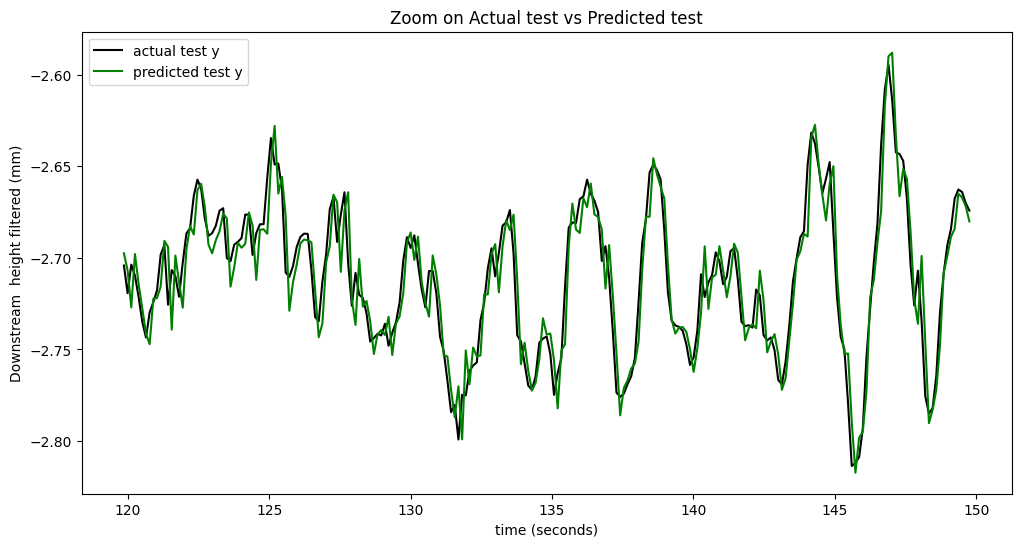

In [ ]:
plt.figure(figsize=(12, 6))
time_ = np.array(time_)
time_ = time_.reshape(-1,1)
time_test = time_[int(train_size*len(time_)):]
plt.plot(time_test, test_data['test_label'], label='actual test y', color='black')
plt.plot(time_test, test_data['predicted_test'], label='predicted test y', color='green')

plt.xlabel('time (seconds)')
plt.ylabel('Downstream  height filtered (mm)')
plt.title('Zoom on Actual test vs Predicted test')
plt.legend()
plt.show()

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','sin']
model.auto_symbolic(lib=lib)
formula = sp.sympify(str(model.symbolic_formula()[0][0]))
formula
def kan_symbolic_formula_prediction(formula, X):
    batch = X.shape[0]
    predictions = []  # Empty list for keeping predictions

    for i in range(batch):
        # Evaluation on symbolic formula on every single fow
        expression = formula
        for j in range(X.shape[1]):
            expression = expression.subs(f'x_{j+1}', X[i, j])

        # Get output of formula
        # Wrap the evalf() call with a try-except block to handle potential errors
        try:
            predicted = float(expression.evalf())
        except (TypeError, ValueError):
            # If an error occurs during evaluation, replace with a default value
            predicted = np.nan  # Or any other suitable default value

        predictions.append(predicted)

    return predictions

# Get results using symbolic formula
preds_from_kan_formula = kan_symbolic_formula_prediction(formula, X_train.to_numpy())

# Before calculating metrics, remove NaN values from predictions and corresponding labels
# using boolean indexing:
valid_indices = ~np.isnan(preds_from_kan_formula)
valid_preds = np.array(preds_from_kan_formula)[valid_indices]
valid_labels = train_labels.numpy()[valid_indices] # Assuming train_labels is a NumPy array

print("MAE from formula on train data",mean_absolute_error(valid_labels, valid_preds))
print("R2 from formula on train data",r2_score(valid_labels, valid_preds))

print("MAE from model.forward() on train data",mean_absolute_error(train_labels.numpy(), train_preds.numpy()))
print("R2 from model.forward() on train data",r2_score(train_labels.numpy(), train_preds.numpy()))


fixing (0,0,0) with x, r2=0.9984608888626099, c=1
fixing (0,0,1) with x, r2=0.9659334421157837, c=1
fixing (0,0,2) with x, r2=0.21480871737003326, c=1
fixing (0,0,3) with x, r2=0.9979414939880371, c=1
fixing (0,0,4) with x, r2=0.9993529319763184, c=1
fixing (0,0,5) with x, r2=0.0434112548828125, c=1
fixing (0,0,6) with x, r2=0.9984675049781799, c=1
fixing (0,0,7) with exp, r2=0.9978268146514893, c=2
fixing (0,0,8) with x, r2=0.995750367641449, c=1
fixing (0,0,9) with sin, r2=0.9994730949401855, c=2
fixing (0,0,10) with x, r2=0.9812708497047424, c=1
fixing (0,0,11) with x, r2=0.8807734847068787, c=1
fixing (0,0,12) with sin, r2=0.996279239654541, c=2
fixing (0,0,13) with x, r2=0.9820103645324707, c=1
fixing (0,0,14) with exp, r2=0.9998872876167297, c=2
fixing (0,0,15) with x, r2=0.8763434886932373, c=1
fixing (0,0,16) with x, r2=0.6653646230697632, c=1
fixing (0,0,17) with x, r2=0.9798933267593384, c=1
fixing (0,0,18) with x, r2=0.870017409324646, c=1
fixing (0,0,19) with exp, r2=0.9987

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


ValueError: array must not contain infs or NaNs

In [ ]:
def kan_symbolic_formula_prediction(formula, X):
    batch = X.shape[0]
    predictions = []  # Empty list for keeping predictions

    for i in range(batch):
        # Evaluation on symbolic formula on every single fow
        expression = formula
        for j in range(X.shape[1]):
            expression = expression.subs(f'x_{j+1}', X[i, j])

        # Get output of formula
        predicted = float(expression.evalf())

        predictions.append(predicted)

    return predictions
# Get results using symbolic formula
preds_from_kan_formula = kan_symbolic_formula_prediction(formula, X_train.to_numpy())

print("MAE from formula on train data",mean_absolute_error(train_labels.numpy(),preds_from_kan_formula))
print("R2 from formula on train data",r2_score(train_labels.numpy(), preds_from_kan_formula))

print("MAE from model.forward() on train data",mean_absolute_error(train_labels.numpy(), train_preds.numpy()))
print("R2 from model.forward() on train data",r2_score(train_labels.numpy(), train_preds.numpy()))

In [ ]:
# plt.plot(y,'r')
# plt.show()
plt.plot(train_label,'b')
plt.plot(train_preds,'b')
plt.show()